# Start session and Import Libraries

First of all, the session in pyspark is started, then the most common libraries that we are going to need in the exploratory analysis and the creation of the model are imported. Next, I will upload the dataset.

In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as func
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [2]:
# Create spark context

sqlCtx = SparkSession.builder.getOrCreate()

# Problem declaration

Telco company is a telecommunications service provider. The company is facing a problem of customer churn.
The objective of this project is to develop a supervised Machine Learning model that can predict customer churn patterns with high precision, using a dataset with historical company data. This prediction will allow the company to make better decisions to retain its customers.
In this Jupyter notebook, I'll explore the data, prepare it for analysis, and train a decision tree model to predict future churn.

# Prediction Churn Mode

## Upload data to be used in the model

Next, the dataset to be used in this model is loaded, and the data will be separated into 70% for model training data and 30% for model test data.

In [4]:
# loanding dataset

Telco = sqlCtx.read.option('header','true').csv('BDA601_Assessment 2_Telco-Customer-Churn_downloaded 05082020 (2).csv')

# Split the dataset in training data and test data

telco_training, telco_test = Telco.randomSplit([0.7, 0.3])
print('telco_training: ',telco_training.count(), 'telco_test: ', telco_test.count())
print(type(telco_test[1]))
print(type(telco_training[0]))

telco_training:  4955 telco_test:  2088
<class 'pyspark.sql.column.Column'>
<class 'pyspark.sql.column.Column'>


## Exploratory Data Analysis 

In this section, the exploratory analysis of the dataset will be carried out in order to have a deeper understanding of the data with which it is going to work, its attributes and their relationship between them. Some conclusions can be drawn without being definitive. I am going to work only with the training data so that the test data is not contaminated, and the model has an adequate performance on the new data, which it has not seen previously.

In [5]:
# Here we will see that the number of rows that the training_set has and the number of columns
print('Number of rows: ',telco_training.count(), '/ Number of columns: ', len(telco_training.columns))

Number of rows:  4955 / Number of columns:  16


In [6]:
# Here we can see the types of data of each attribute and 2 examples of data.
print(telco_training.dtypes)
telco_training.show(2)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'string'), ('Dependents', 'string'), ('tenure', 'string'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string')]
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------------+----------------+----------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------------+----

As we can see above there are numeric attributes that are 'strings such as 'SeniorCitizen', 'tenure' and ' 'TotalCharges', therefore we are going to transform these data into 'Double' to be able to use them later in the exploratory data analysis.

In [7]:
telco_training = telco_training.withColumn('tenure', col('tenure').cast('Double')).withColumn('TotalCharges', col('TotalCharges').cast('Double'))
telco_training.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'double'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

### categorical variables

Now the categorical variables will be analyzed, firstly the numerical outputs will be shown and then they will be displayed, the categorical variables can be displayed to make it easier to understand the data.

In [9]:
categ_col = ['gender','Dependents', 'SeniorCitizen', 'PhoneService','MultipleLines', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']

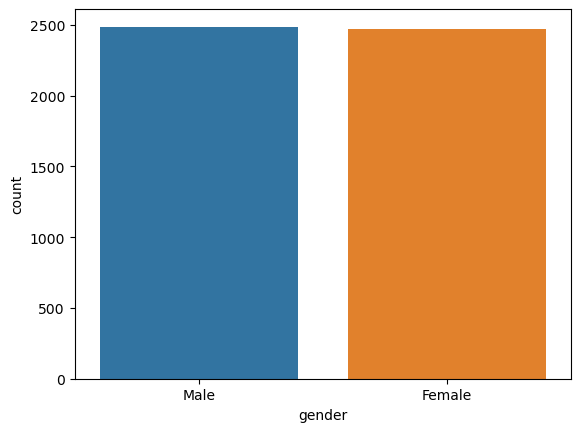

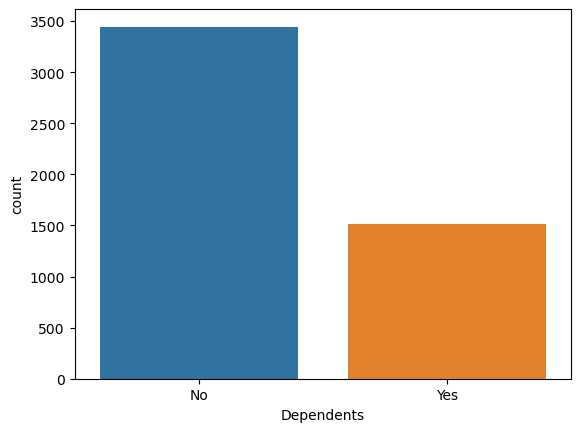

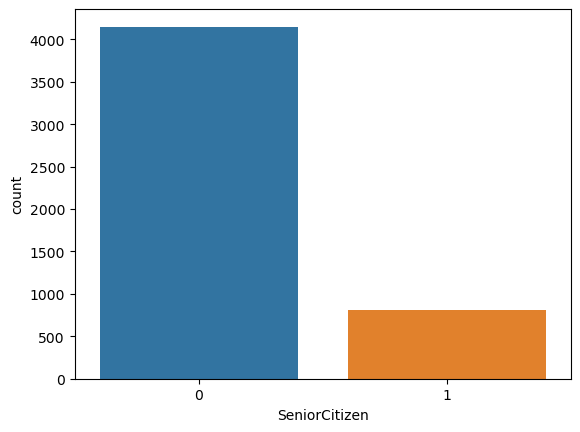

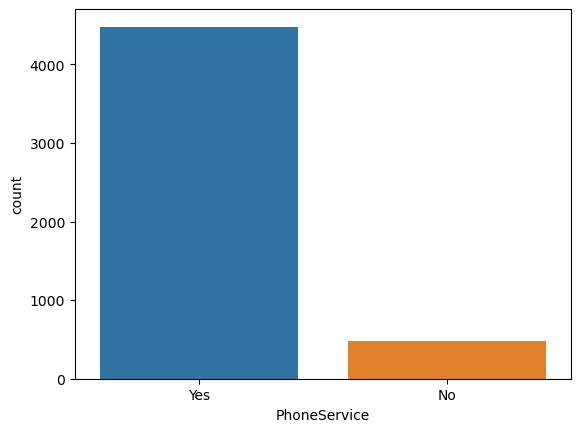

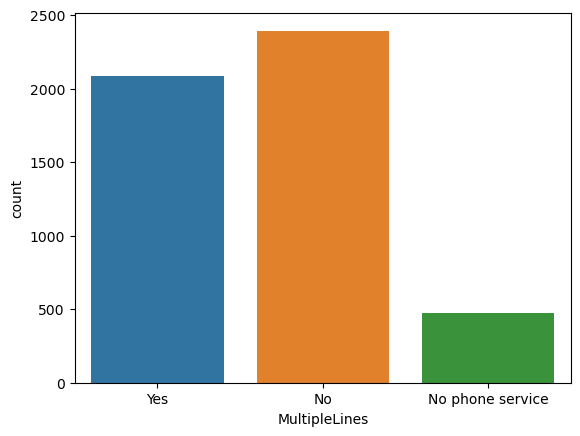

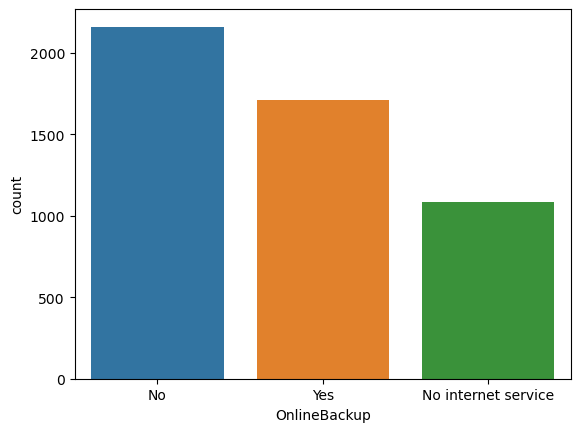

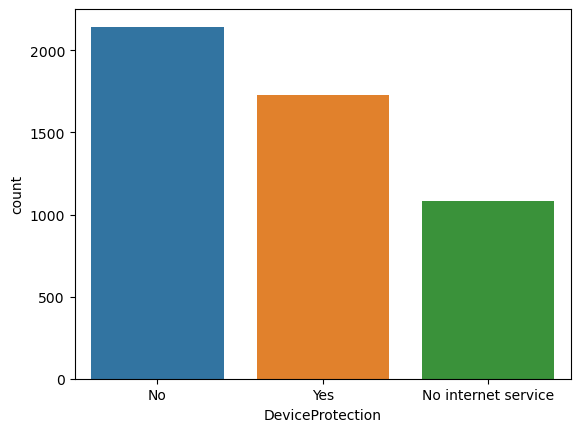

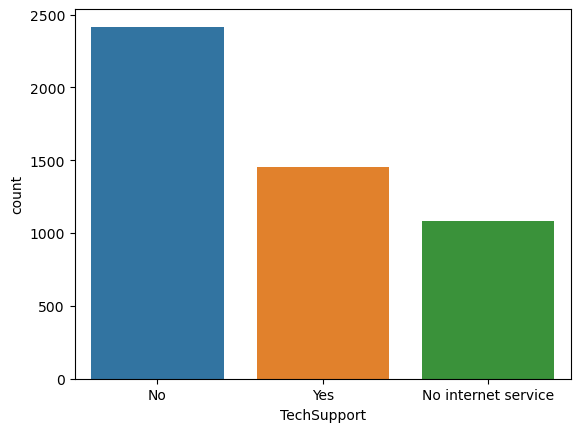

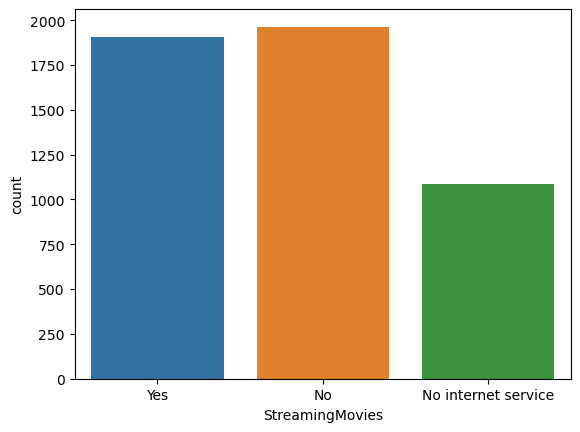

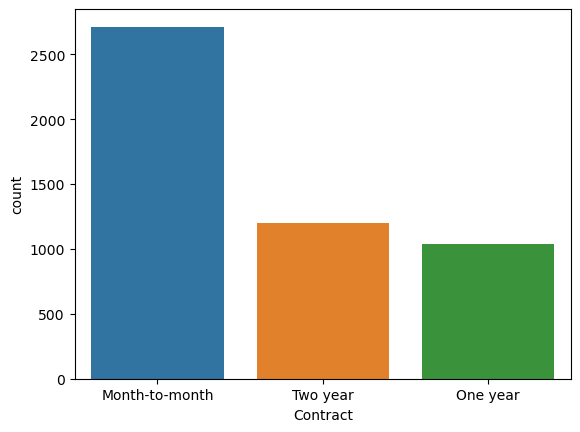

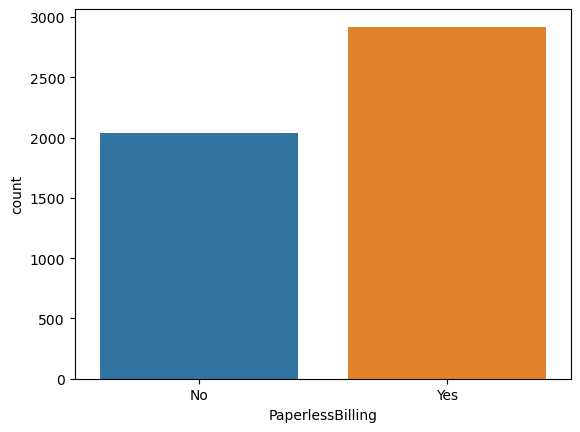

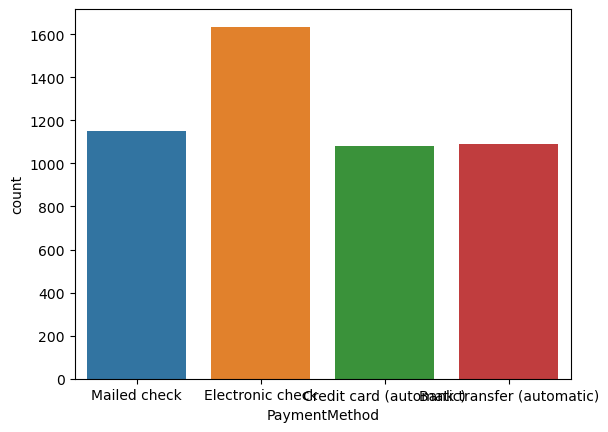

In [26]:
for col in categ_col:
    sns.countplot(x=col, data=telco_training.toPandas())
    plt.show()

Next, the categorical variables that have the greatest numerical difference will be analyzed in order to extract a pattern.

In [10]:
#group the lable with 'Dependents'
telco_training.groupBy('churn', 'Dependents').count().orderBy('count', ascending=False).show()

+-----+----------+-----+
|churn|Dependents|count|
+-----+----------+-----+
|   No|        No| 2368|
|   No|       Yes| 1286|
|  Yes|        No| 1077|
|  Yes|       Yes|  224|
+-----+----------+-----+



In [11]:
#group the lable with 'Phone Service'
telco_training.groupBy('Churn', 'Phoneservice').count().orderBy('count', ascending=False).show()

+-----+------------+-----+
|Churn|Phoneservice|count|
+-----+------------+-----+
|   No|         Yes| 3294|
|  Yes|         Yes| 1184|
|   No|          No|  360|
|  Yes|          No|  117|
+-----+------------+-----+



In [12]:
#group the lable with 'Contract'
telco_training.groupBy('Churn', 'Contract').count().orderBy('count', ascending=False).show()

+-----+--------------+-----+
|Churn|      Contract|count|
+-----+--------------+-----+
|   No|Month-to-month| 1559|
|   No|      Two year| 1171|
|  Yes|Month-to-month| 1154|
|   No|      One year|  924|
|  Yes|      One year|  116|
|  Yes|      Two year|   31|
+-----+--------------+-----+



In [13]:
telco_training.groupBy('Churn', 'SeniorCitizen').count().show()

+-----+-------------+-----+
|Churn|SeniorCitizen|count|
+-----+-------------+-----+
|  Yes|            0|  969|
|   No|            1|  473|
|   No|            0| 3181|
|  Yes|            1|  332|
+-----+-------------+-----+



In [14]:
# Filtering people have left the company and grouping with the other three attributes that differ the most in their results.
telco_training.filter(telco_training.Churn=='Yes').groupby('Dependents','Phoneservice', 'Contract').count().orderBy('count', ascending=False).show()

+----------+------------+--------------+-----+
|Dependents|Phoneservice|      Contract|count|
+----------+------------+--------------+-----+
|        No|         Yes|Month-to-month|  878|
|       Yes|         Yes|Month-to-month|  170|
|        No|          No|Month-to-month|   96|
|        No|         Yes|      One year|   78|
|       Yes|         Yes|      One year|   28|
|        No|         Yes|      Two year|   16|
|       Yes|         Yes|      Two year|   14|
|       Yes|          No|Month-to-month|   10|
|        No|          No|      One year|    8|
|       Yes|          No|      One year|    2|
|        No|          No|      Two year|    1|
+----------+------------+--------------+-----+



In this analysis, information can be extracted such as that there is a high number of clients who have left the company who do not have dependents. It can also be extracted that of the clients that have abandoned the majority have a contracted telephone service. In addition, a very important fact is that of those who have abandoned a high number of them have a month-to-month contract.

Finally, it has been filtered by the clients that have abandoned and grouped by the attributes of 'SeniorCitizen' 'Dependents', 'PhoneService' and 'Contract' and it has been obtained that a large number of abandoned clients have in common that they do not have dependents, they have had contracted telephone service with a month-to-month contract. So that could be a pattern.

### Numeric variables

Next, the numerical attributes are going to be analyzed, obtaining general statistics such as mean, standard deviation, minnimun and maximum to see if there is any pattern between them.

In [28]:
pd_telco_training = telco_training.toPandas()
pd_telco_training.describe()

,tenure,TotalCharges
count,4955.000000,4948.000000
mean,32.663572,2302.921635
std,24.491956,2261.969568
min,0.000000,18.800000
25%,9.000000,411.375000
50%,30.000000,1426.425000
75%,56.000000,3834.350000
max,72.000000,8684.800000


In [15]:
telco_training.select('tenure', 'TotalCharges').describe().show()

+-------+------------------+------------------+
|summary|            tenure|      TotalCharges|
+-------+------------------+------------------+
|  count|              4955|              4948|
|   mean|  32.6635721493441|2302.9216350040415|
| stddev|24.491956012542943|2261.9695675093108|
|    min|               0.0|              18.8|
|    max|              72.0|            8684.8|
+-------+------------------+------------------+



In [16]:
# group by 'Churn' and getting the mean 
telco_training.groupBy('Churn').agg(func.mean('tenure'), func.mean('TotalCharges'),func.stddev('tenure'), func.stddev('TotalCharges')).show()

+-----+------------------+------------------+-------------------+-------------------------+
|Churn|       avg(tenure)| avg(TotalCharges)|stddev_samp(tenure)|stddev_samp(TotalCharges)|
+-----+------------------+------------------+-------------------+-------------------------+
|   No| 37.75177887246853| 2561.809213051822|  24.05175016204574|        2322.380623226125|
|  Yes|18.372790161414297|1577.2006533435813|   19.5757738185142|        1904.892628499841|
+-----+------------------+------------------+-------------------+-------------------------+



<Axes: xlabel='Churn'>

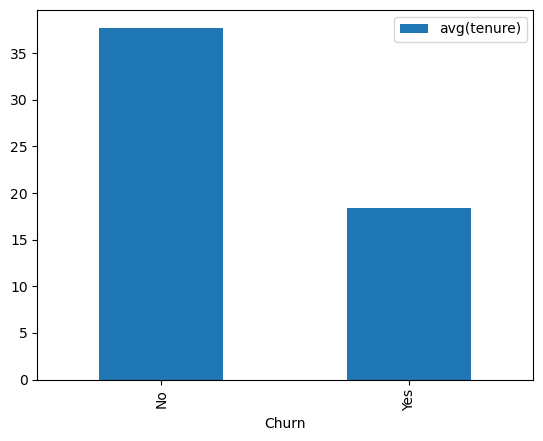

In [17]:

telco_training_churn= telco_training.groupBy('Churn').agg(func.mean('tenure')).orderBy('avg(tenure)', ascending=False)
telco_training_churn.toPandas().plot.bar(x='Churn', y='avg(tenure)')

array([[<Axes: title={'center': 'TotalCharges'}>]], dtype=object)

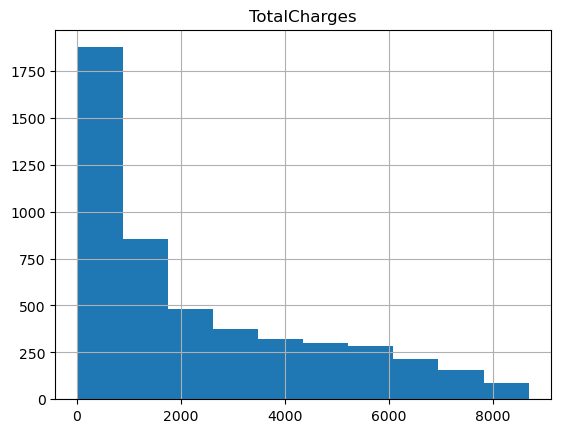

In [18]:
telco_training_hist=telco_training.select('TotalCharges')
telco_training_hist.toPandas().hist(column='TotalCharges')

<Axes: xlabel='tenure', ylabel='TotalCharges'>

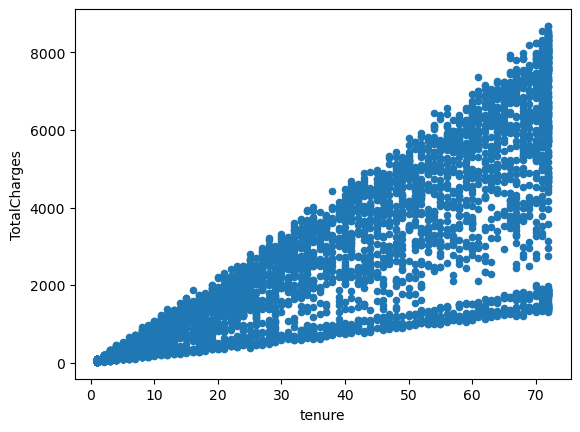

In [19]:
telco_training_sct=telco_training.select('tenure', 'TotalCharges')
telco_training_sct.toPandas().plot.scatter(x='tenure', y='TotalCharges')

### Data cleaning and feature selection

In this section, an analysis will be carried out to find out when values are missing and how many values are repeated to eliminate those rows and make the model more accurate.

#### Null Values

The pandas .info() function returns information such as attribute types and the count of the number of rows in each non-null attribute. Then we can see in the 'TotalCharges' attribute that there are 4970 non-null values and 9 missing values that should be null.

In [20]:
telco_training.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4955 non-null   object 
 1   gender            4955 non-null   object 
 2   SeniorCitizen     4955 non-null   object 
 3   Dependents        4955 non-null   object 
 4   tenure            4955 non-null   float64
 5   PhoneService      4955 non-null   object 
 6   MultipleLines     4955 non-null   object 
 7   OnlineBackup      4955 non-null   object 
 8   DeviceProtection  4955 non-null   object 
 9   TechSupport       4955 non-null   object 
 10  StreamingMovies   4955 non-null   object 
 11  Contract          4955 non-null   object 
 12  PaperlessBilling  4955 non-null   object 
 13  PaymentMethod     4955 non-null   object 
 14  TotalCharges      4948 non-null   float64
 15  Churn             4955 non-null   object 
dtypes: float64(2), object(14)
memory usage: 61

In [21]:
# Seeing and Counting null values
telco_training.filter(telco_training.TotalCharges.isNull()).show()
telco_training.filter(telco_training.TotalCharges.isNull()).count()

+----------+------+-------------+----------+------+------------+-------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+-------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|       OnlineBackup|   DeviceProtection|        TechSupport|    StreamingMovies|Contract|PaperlessBilling|PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+-------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+-------------+------------+-----+
|2520-SGTTA|Female|            0|       Yes|   0.0|         Yes|           No|No internet service|No internet service|No internet service|No internet service|Two year|              No| Mailed check|        null|   No|
|2923-ARZLG|  Male|            0|       Yes|   0.0|         Yes|           No|No internet service|No internet service|No interne

7

Analyzing the null values of the 'TotalCharges' column, it can be concluded that they are new customers who have not been in the company for even a month and have not yet been charged anything. Therefore, I assume my decision to fill up the null values with 0, since they have not yet had any charges.

In [23]:
telco_training_clean = telco_training.fillna({'TotalCharges': 0})

In [25]:
telco_training_clean.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4955 non-null   object 
 1   gender            4955 non-null   object 
 2   SeniorCitizen     4955 non-null   object 
 3   Dependents        4955 non-null   object 
 4   tenure            4955 non-null   float64
 5   PhoneService      4955 non-null   object 
 6   MultipleLines     4955 non-null   object 
 7   OnlineBackup      4955 non-null   object 
 8   DeviceProtection  4955 non-null   object 
 9   TechSupport       4955 non-null   object 
 10  StreamingMovies   4955 non-null   object 
 11  Contract          4955 non-null   object 
 12  PaperlessBilling  4955 non-null   object 
 13  PaymentMethod     4955 non-null   object 
 14  TotalCharges      4955 non-null   float64
 15  Churn             4955 non-null   object 
dtypes: float64(2), object(14)
memory usage: 61

### Duplicate rows

Then with the .count() and .distinct() functions we can obtain how many values are different. In this dataset there are 4,970 rows of which 4,970 are different, therefore there are no duplicate rows.

In [31]:
telco_training_clean.count(), telco_training_clean.distinct().count()

(4955, 4955)

### selection of variables for the model

To train the decision tree model, I am going to select the 'Contract' and 'tenure' attributes to predict whether or not a customer will leave the company.

In [32]:
telco_train = telco_training_clean.select(telco_training_clean.Churn, telco_training_clean.Contract, telco_training_clean.tenure)
telco_train.show(4)
print(telco_train.dtypes)

+-----+--------------+------+
|Churn|      Contract|tenure|
+-----+--------------+------+
|   No|Month-to-month|   9.0|
|  Yes|Month-to-month|  13.0|
|  Yes|Month-to-month|   3.0|
|   No|Month-to-month|   9.0|
+-----+--------------+------+
only showing top 4 rows

[('Churn', 'string'), ('Contract', 'string'), ('tenure', 'double')]


### Transform data to doubleType

The decision model vectors must be Double, so in this step we will transform the label and other attributes from 'string' to 'Double.'

In [33]:
# transform the data from 'string' to double.

churnIndexer = StringIndexer(inputCol = 'Churn', outputCol = 'indexlable')
churnIndexer_fit = churnIndexer.fit(telco_train)
telco_train = churnIndexer_fit.transform(telco_train)

In [34]:
print(telco_train.dtypes)
telco_train.show(5)

[('Churn', 'string'), ('Contract', 'string'), ('tenure', 'double'), ('indexlable', 'double')]
+-----+--------------+------+----------+
|Churn|      Contract|tenure|indexlable|
+-----+--------------+------+----------+
|   No|Month-to-month|   9.0|       0.0|
|  Yes|Month-to-month|  13.0|       1.0|
|  Yes|Month-to-month|   3.0|       1.0|
|   No|Month-to-month|   9.0|       0.0|
|   No|      Two year|  63.0|       0.0|
+-----+--------------+------+----------+
only showing top 5 rows



In [35]:
contractIndexer = StringIndexer(inputCol = 'Contract', outputCol = 'contractIndexer')
contractIndexer_fit = contractIndexer.fit(telco_train)
telco_train = contractIndexer_fit.transform(telco_train)

In [36]:
print(telco_train.dtypes)
telco_train.show(4)

[('Churn', 'string'), ('Contract', 'string'), ('tenure', 'double'), ('indexlable', 'double'), ('contractIndexer', 'double')]
+-----+--------------+------+----------+---------------+
|Churn|      Contract|tenure|indexlable|contractIndexer|
+-----+--------------+------+----------+---------------+
|   No|Month-to-month|   9.0|       0.0|            0.0|
|  Yes|Month-to-month|  13.0|       1.0|            0.0|
|  Yes|Month-to-month|   3.0|       1.0|            0.0|
|   No|Month-to-month|   9.0|       0.0|            0.0|
+-----+--------------+------+----------+---------------+
only showing top 4 rows



### Assambler vector in a column

To build a decision tree, it is necessary to have several vectors assembled in the same matrix, and each vector represents a question or decision based on the characteristics of the matrix. To assemble the vectors in the matrix we will use the .Assembler() function.

In [37]:
featuresAssembler = VectorAssembler(inputCols = ['tenure', 'contractIndexer'], outputCol = 'features')
telco_train = featuresAssembler.transform(telco_train)
telco_train.show(5)

+-----+--------------+------+----------+---------------+----------+
|Churn|      Contract|tenure|indexlable|contractIndexer|  features|
+-----+--------------+------+----------+---------------+----------+
|   No|Month-to-month|   9.0|       0.0|            0.0| [9.0,0.0]|
|  Yes|Month-to-month|  13.0|       1.0|            0.0|[13.0,0.0]|
|  Yes|Month-to-month|   3.0|       1.0|            0.0| [3.0,0.0]|
|   No|Month-to-month|   9.0|       0.0|            0.0| [9.0,0.0]|
|   No|      Two year|  63.0|       0.0|            1.0|[63.0,1.0]|
+-----+--------------+------+----------+---------------+----------+
only showing top 5 rows



In [38]:
telco_train_output=telco_train.select(telco_train.indexlable, telco_train.features)
telco_train_output.show(5)

+----------+----------+
|indexlable|  features|
+----------+----------+
|       0.0| [9.0,0.0]|
|       1.0|[13.0,0.0]|
|       1.0| [3.0,0.0]|
|       0.0| [9.0,0.0]|
|       0.0|[63.0,1.0]|
+----------+----------+
only showing top 5 rows



## Test data

Next, the test data is prepared in the same way that the training data was prepared.

In [39]:
telco_test = telco_test.withColumn('TotalCharges', func.col('TotalCharges').cast(DoubleType()))
telco_test1 = telco_test.withColumn('tenure', func.col('tenure').cast(DoubleType()))

In [40]:
print(telco_test1.dtypes)
telco_test1.show(4)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'string'), ('Dependents', 'string'), ('tenure', 'double'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'double'), ('Churn', 'string')]
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+-----------

In [41]:
telco_test1.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2088 entries, 0 to 2087
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2088 non-null   object 
 1   gender            2088 non-null   object 
 2   SeniorCitizen     2088 non-null   object 
 3   Dependents        2088 non-null   object 
 4   tenure            2088 non-null   float64
 5   PhoneService      2088 non-null   object 
 6   MultipleLines     2088 non-null   object 
 7   OnlineBackup      2088 non-null   object 
 8   DeviceProtection  2088 non-null   object 
 9   TechSupport       2088 non-null   object 
 10  StreamingMovies   2088 non-null   object 
 11  Contract          2088 non-null   object 
 12  PaperlessBilling  2088 non-null   object 
 13  PaymentMethod     2088 non-null   object 
 14  TotalCharges      2084 non-null   float64
 15  Churn             2088 non-null   object 
dtypes: float64(2), object(14)
memory usage: 26

In [42]:
# there are four null values going to those substituted by 0.
telco_test1_clean = telco_test1.fillna({'TotalCharges': 0})
telco_test1_clean.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2088 entries, 0 to 2087
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2088 non-null   object 
 1   gender            2088 non-null   object 
 2   SeniorCitizen     2088 non-null   object 
 3   Dependents        2088 non-null   object 
 4   tenure            2088 non-null   float64
 5   PhoneService      2088 non-null   object 
 6   MultipleLines     2088 non-null   object 
 7   OnlineBackup      2088 non-null   object 
 8   DeviceProtection  2088 non-null   object 
 9   TechSupport       2088 non-null   object 
 10  StreamingMovies   2088 non-null   object 
 11  Contract          2088 non-null   object 
 12  PaperlessBilling  2088 non-null   object 
 13  PaymentMethod     2088 non-null   object 
 14  TotalCharges      2088 non-null   float64
 15  Churn             2088 non-null   object 
dtypes: float64(2), object(14)
memory usage: 26

### Duplicate rows testting data

Then with the .count() and .distinct() functions we can obtain how many values are different. In this dataset there are 2,062 rows of which 2,062 are different, therefore there are no duplicate rows.

In [43]:
telco_test1_clean.count(), telco_test1_clean.distinct().count()

(2088, 2088)

### selection of variables of testing data

In [44]:
telco_test = telco_test1_clean.select(telco_test1_clean.Churn, telco_test1_clean.tenure, telco_test1_clean.Contract)
telco_test.show(5)
print(telco_test.dtypes)

+-----+------+--------------+
|Churn|tenure|      Contract|
+-----+------+--------------+
|   No|   9.0|      One year|
|  Yes|   4.0|Month-to-month|
|   No|  71.0|      Two year|
|   No|   7.0|Month-to-month|
|   No|   1.0|Month-to-month|
+-----+------+--------------+
only showing top 5 rows

[('Churn', 'string'), ('tenure', 'double'), ('Contract', 'string')]


### Transform data to doubleType

In [45]:
churnIndexer = StringIndexer(inputCol = 'Churn', outputCol = 'indexlable')
churnIndexer_fit = churnIndexer.fit(telco_test)
telco_test = churnIndexer_fit.transform(telco_test)

In [46]:
telco_test.dtypes

[('Churn', 'string'),
 ('tenure', 'double'),
 ('Contract', 'string'),
 ('indexlable', 'double')]

In [47]:
contractIndexer = StringIndexer(inputCol = 'Contract', outputCol = 'contractIndexer')
contractIndexer_fit = contractIndexer.fit(telco_test)
telco_test = contractIndexer_fit.transform(telco_test)
telco_test.show(10)

+-----+------+--------------+----------+---------------+
|Churn|tenure|      Contract|indexlable|contractIndexer|
+-----+------+--------------+----------+---------------+
|   No|   9.0|      One year|       0.0|            2.0|
|  Yes|   4.0|Month-to-month|       1.0|            0.0|
|   No|  71.0|      Two year|       0.0|            1.0|
|   No|   7.0|Month-to-month|       0.0|            0.0|
|   No|   1.0|Month-to-month|       0.0|            0.0|
|   No|  50.0|      One year|       0.0|            2.0|
|   No|  23.0|Month-to-month|       0.0|            0.0|
|   No|   3.0|Month-to-month|       0.0|            0.0|
|  Yes|   1.0|Month-to-month|       1.0|            0.0|
|   No|  12.0|      Two year|       0.0|            1.0|
+-----+------+--------------+----------+---------------+
only showing top 10 rows



### Assembler vector

In [48]:
featureAssembler = VectorAssembler(inputCols = ['tenure', 'contractIndexer'], outputCol = 'features')
telco_test = featureAssembler.transform(telco_test)
telco_test = telco_test.select(['indexlable', 'features'])
telco_test.show(5)

+----------+----------+
|indexlable|  features|
+----------+----------+
|       0.0| [9.0,2.0]|
|       1.0| [4.0,0.0]|
|       0.0|[71.0,1.0]|
|       0.0| [7.0,0.0]|
|       0.0| [1.0,0.0]|
+----------+----------+
only showing top 5 rows



# Prediction and Accuracy

Now, the decision tree model is created with the matrix created as the characteristics of the columns and the label as the variable to be predicted, in this case 'Churn'.

The decision tree model is then trained using the "telco_train" training data using the "fit" method. This tunes the parameters of the model so that it can make accurate predictions on the test data.

After the "telco_test" data is used to make predictions using the trained model. The "transform" methodis used to apply the model to the test data and generate predictions.

In [49]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'indexlable')

dtc = dtc.fit(telco_train)

pred = dtc.transform(telco_test)

pred.show(10)

+----------+----------+--------------+--------------------+----------+
|indexlable|  features| rawPrediction|         probability|prediction|
+----------+----------+--------------+--------------------+----------+
|       0.0| [9.0,2.0]|[2095.0,147.0]|[0.93443354148082...|       0.0|
|       1.0| [4.0,0.0]| [125.0,119.0]|[0.51229508196721...|       0.0|
|       0.0|[71.0,1.0]|[2095.0,147.0]|[0.93443354148082...|       0.0|
|       0.0| [7.0,0.0]|[1159.0,642.0]|[0.64353137146029...|       0.0|
|       0.0| [1.0,0.0]| [158.0,256.0]|[0.38164251207729...|       1.0|
|       0.0|[50.0,2.0]|[2095.0,147.0]|[0.93443354148082...|       0.0|
|       0.0|[23.0,0.0]|[1159.0,642.0]|[0.64353137146029...|       0.0|
|       0.0| [3.0,0.0]| [125.0,119.0]|[0.51229508196721...|       0.0|
|       1.0| [1.0,0.0]| [158.0,256.0]|[0.38164251207729...|       1.0|
|       0.0|[12.0,1.0]|[2095.0,147.0]|[0.93443354148082...|       0.0|
+----------+----------+--------------+--------------------+----------+
only s

## Classification model evaluation

In [50]:
tp = pred.filter((pred.indexlable == 1) & (pred.prediction == 1)).count()

tn = pred.filter((pred.indexlable == 0) & (pred.prediction == 0)).count()

fp = pred.filter((pred.indexlable == 0) & (pred.prediction == 1)).count()

fn = pred.filter((pred.indexlable == 1) & (pred.prediction == 0)).count()

print('True Positive', tp)
print('True negative', tn)
print('False positive', fp)
print('False negative', fn)

# accurancy

a = ((tp + tn) / pred.count())

#recall

r = float (tp) / (tp + fn)

#precision

p = float (tp) / (tp + fp)

#F1

f1 = 2 *((p * r) / (p + r))

print('Accuracy', a)
print('recall', r)
print('precision', p)
print('F1 score', f1)

True Positive 171
True negative 1397
False positive 123
False negative 397
Accuracy 0.7509578544061303
recall 0.301056338028169
precision 0.5816326530612245
F1 score 0.3967517401392111
